In [1]:
%pip install pyspark==3.1.1 pyarrow tldextract

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.executable

'/usr/local/anaconda3/envs/ada/bin/python'

In [3]:
# Make sure that spark uses the same python distribution to avoid serialization issues due to missing packages
%env PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
%env PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python

env: PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
env: PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python


In [29]:
# Data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, DoubleType

# Helpers
import os
import json

# External libraries
import profanity_check
import tldextract

In [5]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','8G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.sql.execution.arrow.maxRecordsPerBatch', 10000),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2').getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
spark

:: loading settings :: url = jar:file:/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/MDS/.ivy2/cache
The jars for the packages stored in: /Users/MDS/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ca5a238b-b5e1-46fa-a818-aca39c110586;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1

In [50]:
DATA_DIR    = 'data/'
QB_DATA_DIR = DATA_DIR + 'quotebank_data/'

QB_DATA_JSON_PATH     = QB_DATA_DIR + 'json/quotes-%s.json'
QB_DATA_JSON_BZ2_PATH = QB_DATA_DIR + 'json/quotes-%s.json.bz2'
QB_DATA_PARQUET_PATH  = QB_DATA_DIR + 'parquet/quotes-%s.parquet'
QB_DATA_PROC_PATH     = QB_DATA_DIR + 'processed/quotes-%s.parquet' # contains qb data with profanity scores, tlds, prominent speaker qid, prominent speaker prob, prominent speaker label

SPK_ATTR_PATH             = DATA_DIR + 'speaker_attributes.parquet'
SPK_ATTR_WITH_LABELS_PATH = DATA_DIR + 'speaker_attributes_with_labels.parquet'

LABELS_PATH = DATA_DIR + 'wikidata_labels_descriptions_quotebank.csv.bz2'

YEARS = ['2020']

In [7]:
QB_JSON_SCHEMA = StructType.fromJson(json.loads(
    '''{  "type": "struct", 
        "fields": [
            {"name": "date", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "numOccurrences", "type": "long", "nullable": true,"metadata": {}}, 
            {"name": "phase", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "probas", "type": 
            {"type": "array", "elementType": {"type": "array", "elementType": "string", "containsNull": true}, "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "qids", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "quotation", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "quoteID", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "speaker", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "urls", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}
            ]
    }'''))

### Load the labels of QIDS

In [8]:
labels = pd.read_csv(LABELS_PATH)
labels = labels.set_index("QID")

### Expand speaker attributes with labels

In [9]:
def qids_to_attr_labels(qids):
    if qids is None or len(qids) == 0:
        return []
    return list(map(lambda qid : labels.Label[qid] if qid in labels.index else qid, qids))

In [10]:
def map_missing(iterator):
    for df in iterator:
        for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
            df[col + '_labels'] = df[col].apply(qids_to_attrib_labels)
        yield df

In [11]:
def expand_spk_attr_with_labels():
    spk_attr = spark.read.parquet(SPK_ATTR_PATH)
    for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
        spk_attr = spk_attr.withColumn(col + '_labels', spk_attr[col])
    spk_attr.write.parquet(SPK_ATTR_WITH_LABELS_PATH, 'overwrite')

In [51]:
# Uncomment for the first-run to save the processed files
# expand_spk_attr_with_labels()

In [52]:
# Load expanded data
spk_attr = spark.read.parquet(SPK_ATTR_WITH_LABELS_PATH)

### Expand the quotebank data with top-level-domains, profanity-scores, etc. and save for eaiser loading in the future

In [48]:
def url_list_to_tlds(urls):
    if urls is None or len(urls) == 0:
        return None
    res = list(map(lambda url : tldextract.extract(url).domain, urls))
    return res if res else None

In [47]:
def fill_columns(iterator):
    for df in iterator:
        df['profanity'] = profanity_check.predict_prob(df.quotation)
        df['speaker_qid'] = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else qids[0])         
        df['speaker_label'] = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else (labels.Label[qids[0]] if qids[0] in labels.index else None))
        df['tlds'] = df['urls'].apply(url_list_to_tlds)
        df['speaker_prob'] = df['probas'].apply(lambda p : 0.0 if (p is None or len(p) == 0) else float(p[0][1]))
        yield df

In [46]:
def prepare_data(df):    
    df = df.withColumn('speaker_qid', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_label', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_prob', f.lit(None).cast(DoubleType()))
    df = df.withColumn('tlds', df.urls)
    df = df.withColumn('profanity', f.lit(None).cast(DoubleType()))
    df = df.mapInPandas(fill_columns, schema = df.schema)
    return df

In [44]:
def prepare_data_for_years(years):
    for y in years:
        df = spark.read.json(QB_DATA_JSON_PATH % y, schema=QB_JSON_SCHEMA)
        df = prepare_data(df)
        df.write.parquet(QB_DATA_PROC_PATH % y, 'overwrite')

In [49]:
# Uncomment for the first-run to save the processed files
#prepare_data_for_years(YEARS)

In [53]:
qb = spark.read.parquet(QB_DATA_PROC_PATH % YEARS[0])
for y in YEARS[1:]:
    qb = qb.union(spark.read_parquet(QB_DATA_PROC_PATH % y))

### Top news domains with high profanity quotes

In [54]:
def profanity_by_news_outlet(df, min_quotes = 10000):
    return df \
        .withColumn('tld', f.explode('tlds')) \
        .groupby('tld') \
        .agg(f.avg('profanity').alias('avg_profanity'), f.count('quotation').alias('count')) \
        .where(f.col('count') >= min_quotes) \
        .sort('avg_profanity', ascending=False)

In [55]:
profanity_by_news_outlet(qb, 10000).show()

+------------------+-------------------+-----+
|               tld|      avg_profanity|count|
+------------------+-------------------+-----+
|               nme|0.12396075646092378|10657|
|thehollywoodgossip| 0.1010810278703445|12271|
|         inquisitr|0.09300202883093707|23046|
|           eonline|0.08896868517040082|11800|
|     thedailybeast|0.08871525342695481|13377|
|        cheatsheet|0.08829257405797264|29177|
|          etcanada|0.08813149158649779|10862|
|            thesun|0.08797538194233366|35166|
|        usmagazine|0.08560456494210512|13111|
|            people|0.08506631683579856|26263|
|              vice|0.08398846484226385|12531|
|       femalefirst|0.08353762173273721|13719|
|         wordpress|0.08251095076109365|21260|
|            mirror|0.08032704952593808|46170|
|         billboard|0.08022228466629261|15511|
|         dailystar|0.08013808967264716|29499|
|       irishmirror|0.07977294491611693|29566|
| hollywoodreporter|0.07638583168069987|11697|
|            

### Quote distribution by profession

In [61]:
occupation_stats = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .withColumn('profession', f.explode('occupation_labels')) \
    .groupby('profession') \
    .agg(f.count('quotation').alias('count')) \
    .sort('count', ascending=False).limit(10).toPandas()

Text(0, 0.5, 'Profession')

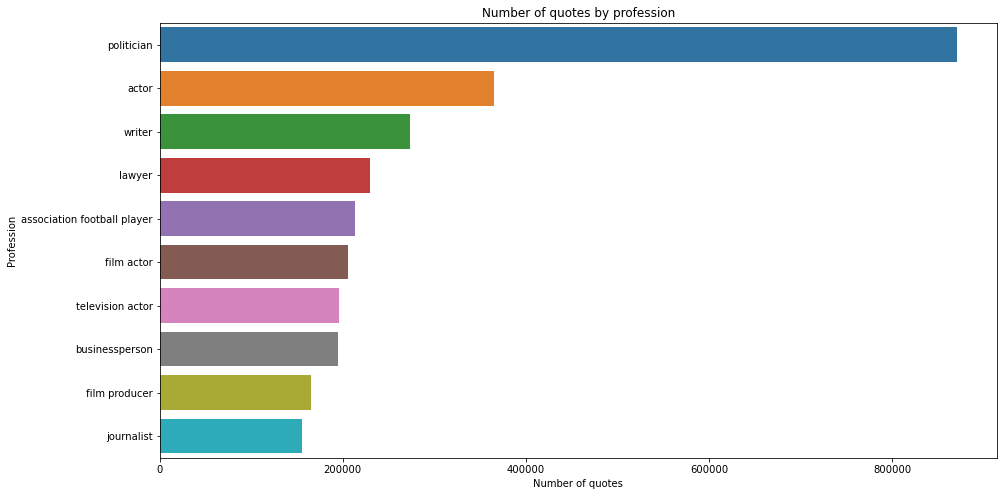

In [63]:
occupation_stats['profession_label'] = occupation_stats.profession.apply(lambda qid : labels.Label[qid])
plt.figure(figsize=(15,8))
sns.barplot(y='profession_label', x='count', data=occupation_stats)
plt.title("Number of quotes by profession")
plt.xlabel("Number of quotes")
plt.ylabel("Profession")

## Temporal Analysis

In [64]:
# Extract the yyyy-mm part from the date
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

In [65]:
def normalize(key, pdf):
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.profanity.mean() ], "sem" : [ pdf.profanity.sem() ]})

In [66]:
def plot_distribution(df, title):
    plt.figure(figsize=(6,8))
    plt.ylim(0.99 * df['mean'].min(), 1.01 * df['mean'].max())
    sns.barplot(x=df["key"], y=df["mean"], yerr=1.96*df["sem"])
    plt.xlabel("month")
    plt.ylabel("average profanity with 95% error bars")
    plt.title(title)
    plt.show()

In [67]:
d1 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [68]:
d2 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .where( (qb.speaker != "President Donald Trump") \
               & (qb.speaker != "President Trump") \
               & (qb.speaker != "Donald Trump") ) \
        .groupby("date") \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

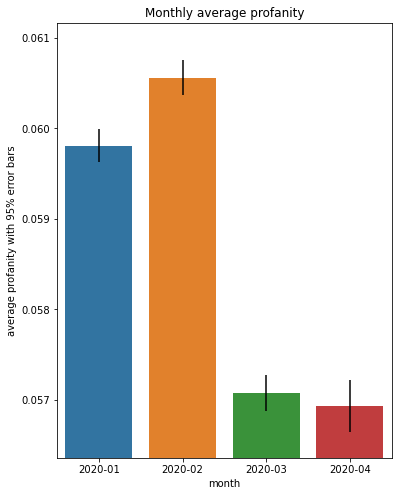

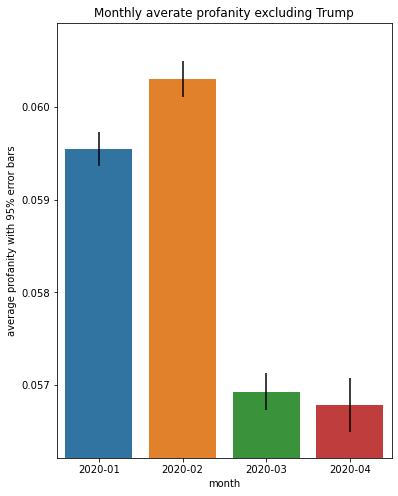

In [69]:
plot_distribution(d1, "Monthly average profanity")
plot_distribution(d2, "Monthly averate profanity excluding Trump")

(0.05621509567879076, 0.06116344827488733)

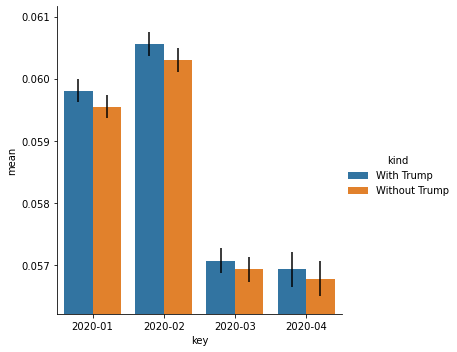

In [70]:
d1['kind'] = 'With Trump'
d2['kind'] = 'Without Trump'
d = pd.concat([d1, d2])
sns.catplot(x='key', y='mean', hue='kind', data=d, kind='bar', yerr=1.96 * d1['sem'])
plt.ylim(0.99 * d['mean'].min(), 1.01 * d['mean'].max())